In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, preps, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(preps)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

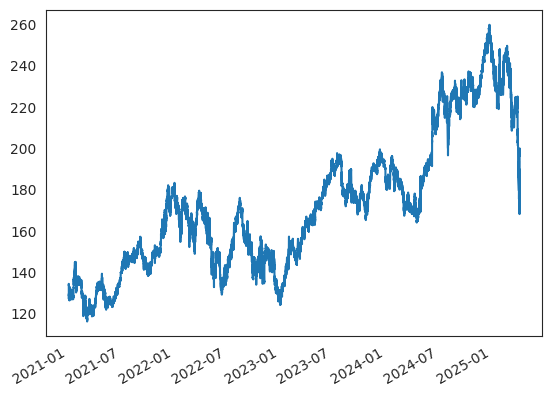

,range_pct,atr_pct_7,atr_pct_28,time_afthour,time_premark,kc_w_20_20_2.0,bb_w_20_2p0,donch_w_20,ret_std_63,atr_pct_14,donch_w_55,ret_std_21,upper_shad,time_in_sess,dist_high_200,bb_w_50_2p0,lower_shad,time_hour,dist_low_200,time_week_of_year,trade_count,volume,atr_7_RZ,atr_14_RZ,atr_28_RZ,time_day_of_year,time_month,vol_spike_28,plus_di_28,stoch_k_14_3_3,rolling_max_close_200_RZ,adx_14,minus_di_28,minus_di_14,cci_20,plus_di_7,plus_di_14,adx_28,rsi_6,rolling_min_close_200_RZ,vol_spike_14,stoch_d_9_3_3,sma_5_RZ,minus_di_7,sma_21_RZ,sma_9_RZ,cci_14,sma_pct_200,stoch_k_9_3_3,cmf_14,close_raw,signal_raw,signal_thresh,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,pred_signal,ask,bid
2021-01-04 08:59:00,0.000000,0.098868,0.152824,0.0,1.0,0.148880,0.204431,0.181057,0.403301,0.137741,0.132061,0.161979,0.0000,0.0,0.094020,0.175921,0.000000,0.270833,0.247333,0.500000,0.005609,0.001592,0.101569,0.135265,0.181819,0.508219,0.50,0.229192,0.323166,0.509259,0.60294,0.478070,0.594159,0.553825,0.435351,0.231632,0.206528,0.424790,0.465950,0.366904,0.279944,0.911111,0.447165,0.414991,0.464347,0.450516,0.654844,0.671319,0.966667,0.753950,133.6000,0.909356,0.122127,0.051385,47.163628,46.676007,133.748956,0.115846,133.626720,133.573280
2021-01-04 09:00:00,0.000000,0.084390,0.147048,0.0,1.0,0.141106,0.181736,0.181057,0.403201,0.127555,0.132061,0.162328,0.0000,0.0,0.094020,0.176850,0.000000,0.312500,0.247333,0.500000,0.004335,0.016740,0.095594,0.126676,0.175434,0.508219,0.50,1.000000,0.323166,0.759259,0.60294,0.471534,0.594159,0.553825,0.443617,0.231632,0.206528,0.418551,0.465950,0.366904,1.000000,0.955556,0.447340,0.414991,0.463189,0.450516,0.647074,0.669978,1.000000,0.642352,133.6000,1.030426,0.122127,0.047715,46.645554,46.676007,133.730371,0.117812,133.626720,133.573280
2021-01-04 09:01:00,0.021671,0.165209,0.167365,0.0,1.0,0.169368,0.181736,0.162087,0.416932,0.167328,0.131788,0.258522,0.0000,0.0,0.036622,0.175071,0.000000,0.312500,0.305650,0.500000,0.002040,0.000035,0.138997,0.153787,0.195086,0.508219,0.50,0.023953,0.498311,1.000000,0.60294,0.442446,0.492098,0.388693,0.826210,0.676979,0.493183,0.402177,0.863385,0.366904,0.021654,0.988889,0.452073,0.183483,0.463121,0.452844,1.000000,0.733116,1.000000,0.657188,133.8500,0.194603,0.122127,0.062164,44.340221,86.304255,133.730609,0.119316,133.876770,133.823230
2021-01-04 09:02:00,0.065008,0.152447,0.164197,0.0,1.0,0.164821,0.183896,0.171385,0.416752,0.160953,0.131777,0.258320,0.0000,0.0,0.034331,0.174567,0.076923,0.312500,0.307978,0.500000,0.005609,0.000657,0.133980,0.147694,0.191463,0.508219,0.50,0.079712,0.516535,0.982456,0.60294,0.419121,0.481479,0.374027,0.846966,0.702613,0.518641,0.387855,0.868116,0.366904,0.079612,0.994152,0.456806,0.170158,0.463161,0.456104,0.993874,0.734039,0.982456,0.619909,133.8600,0.176409,0.122127,0.059867,42.491576,86.775978,133.731450,0.121846,133.886772,133.833228
2021-01-04 09:03:00,0.129997,0.152698,0.164269,0.0,1.0,0.164781,0.190488,0.187649,0.226139,0.160954,0.131756,0.258747,0.2800,0.0,0.029749,0.174876,0.115385,0.312500,0.312633,0.500000,0.006119,0.000999,0.134784,0.148219,0.192064,0.508219,0.50,0.108525,0.528106,0.954344,0.60294,0.401620,0.460638,0.345751,0.864319,0.687930,0.530939,0.375724,0.878242,0.366904,0.114315,0.977934,0.459509,0.145477,0.463283,0.458711,0.845026,0.737541,0.951345,0.583329,133.8800,0.099948,0.122127,0.059876,41.104585,87.785655,133.732774,0.125915,133.906776,133.853224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09 23:55:00,0.085630,0.300793,0.309880,1.0,0.0,0.304674,0.129456,0.151655,0.294632,0.303083,0.265020,0.259218,0.0000,0.0,0.296614,0.218934,0.000000,0.895833,0.184530,0.769231,0.010709,0.000629,0.200956,0.217832,0.207866,0.768493,0.75,0.063822,0.337247,0.518768,0.60294,0.155866,0.282251,0.253984,0.528917,0.161636,0.25

In [3]:
###### ML STRATEGIES DF ######

df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)

df_trainval.close_raw.plot() ; plt.show()
df_trainval

In [4]:
# ##### 5 ######
# {'reset_peak': (1, 1),
#  'rsi_min_thresh': (-4, 14),
#  'rsi_max_thresh': (22, 86),
#  'adx_thresh': (17.6346751055209, 32.6331348944791),
#  'atr_mult': (10.111080612459546, 24.229439387540452),
#  'vwap_atr_mult': (-11.827546718725316, 6.848886718725315),
#  'buy_factor': (-0.12576810118350074, 0.5344681011835006),
#  'sell_factor': (-0.07133474213353949, 0.1105847421335395),
#  'trailstop_pct': (4.382677321445973, 30.217002678554024),
#  'thresh_choice': {'categorical': ['p99', 'roll_p90', 'mean']},
#  'thresh_value': (0.5206000000000001, 1.1725599999999998),
#  'thresh_window': (19.933164128731846, 230.06683587126815)}

In [5]:
col_signal = "pred_signal"

groups = df_trainval.groupby(df_trainval.index.normalize())

prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [True, False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 0, 30)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 30), 90)
    adx_thresh       = trial.suggest_float("adx_thresh", 10.0, 40.0)
    atr_mult         = trial.suggest_float("atr_mult", 5, 30, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", -10, 7)
    buy_factor       = trial.suggest_float("buy_factor", 0.01, 0.7)
    sell_factor      = trial.suggest_float("sell_factor", 0.01, 0.3)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 3.0, 35.0)
    thresh_choice = trial.suggest_categorical("thresh_choice",
        ["p95", "p99", "mean", "roll_p90", "numeric"])

    if thresh_choice == "numeric":
        thresh_mode = trial.suggest_float("thresh_value", 0.3, 3)
        thresh_window = None
    else: # signal threshold
        thresh_mode = thresh_choice
        thresh_window = trial.suggest_int("thresh_window", 15, 250) if thresh_choice.startswith("roll") else None

    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))
    
    df_thresh = preps.apply_thresholds_per_day(
        df = df_trainval.copy(),
        col_signal = col_signal,  
        thresh_mode = thresh_mode,
        thresh_window = thresh_window,
    )

    start_ask = df_thresh.loc[df_thresh.index.normalize() == df_thresh.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = col_signal,
            sign_thresh     = "signal_thresh",
            col_atr         = 'atr_14_raw',
            col_adx         = 'adx_14_raw',
            col_rsi         = 'rsi_6_raw',
            col_vwap        = 'vwap_ohlc_close_session_raw',
            col_close       = 'close_raw',
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: 44.6885


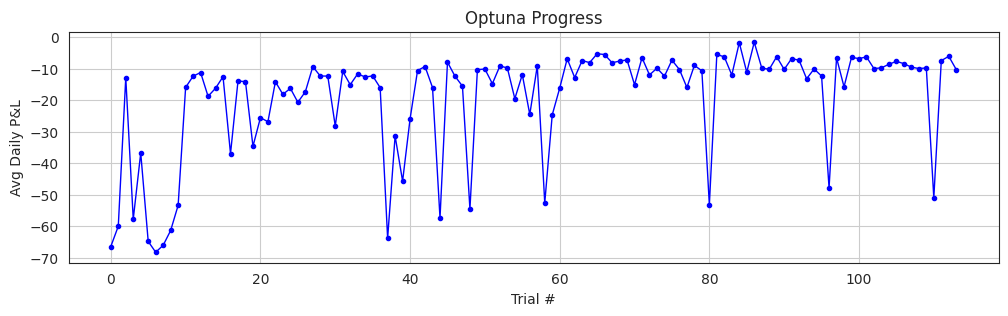

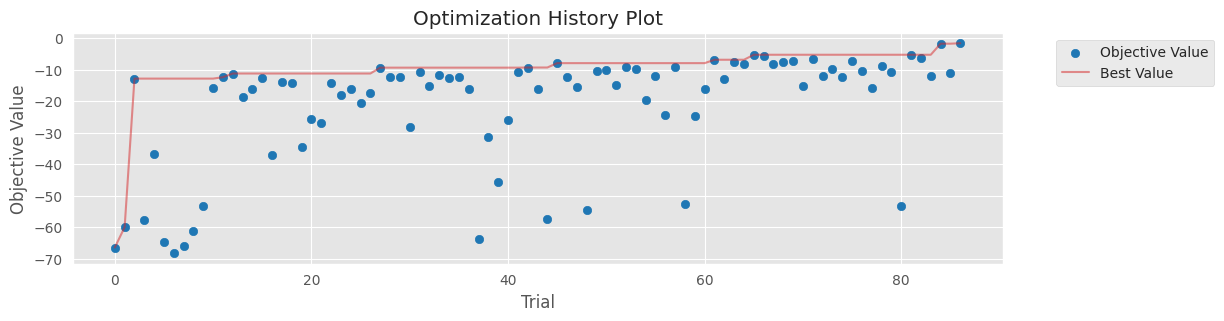

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=71; adx_thresh=37.58981583606345; atr_mult=27.954021996794783; vwap_atr_mult=-7.245985264344101; buy_factor=0.35988749695768885; sell_factor=0.2876662672477422; trailstop_pct=5.176921518344276; thresh_choice=p99


Trial 0: 100%|██████████| 1072/1072 [03:41<00:00,  4.83it/s]


[Results] mean_pnl:-21.0324 mean_bh:45.3970 mean_excess:-66.4294 improv_vs_bh:-146.33%
Action counts: {'Buy': 5779, 'Sell': 9954, 'Hold': 934243}
Best trial is: 0 with best_val: -66.4294
[save_results] wrote optuna_results/AAPL_-66.4294_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-66.4294_pred_ML.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=25; rsi_max_thresh=40; adx_thresh=19.25417314082712; atr_mult=23.226259240918907; vwap_atr_mult=-8.235098997883233; buy_factor=0.43389830406110885; sell_factor=0.18319405081085957; trailstop_pct=26.70456624325541; thresh_choice=numeric; thresh_value=2.099443028436737


Trial 1: 100%|██████████| 1072/1072 [03:23<00:00,  5.28it/s]


[Results] mean_pnl:-14.6006 mean_bh:45.3970 mean_excess:-59.9976 improv_vs_bh:-132.16%
Action counts: {'Buy': 7976, 'Sell': 16410, 'Hold': 925590}
Best trial is: 1 with best_val: -59.9976
[save_results] wrote optuna_results/AAPL_-59.9976_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-59.9976_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=74; adx_thresh=11.834472598734461; atr_mult=13.717093128850722; vwap_atr_mult=4.365458960579385; buy_factor=0.22214848764210288; sell_factor=0.09591459840591413; trailstop_pct=5.11567339557887; thresh_choice=mean


Trial 2: 100%|██████████| 1072/1072 [03:59<00:00,  4.48it/s]


[Results] mean_pnl:32.5244 mean_bh:45.3970 mean_excess:-12.8726 improv_vs_bh:-28.36%
Action counts: {'Buy': 12297, 'Sell': 1938, 'Hold': 935741}
Best trial is: 2 with best_val: -12.8726
[save_results] wrote optuna_results/AAPL_-12.8726_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-12.8726_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=39; adx_thresh=37.70731008135155; atr_mult=13.201494241456905; vwap_atr_mult=0.3236298764430092; buy_factor=0.35844063927243514; sell_factor=0.038901375271889256; trailstop_pct=12.653267442078512; thresh_choice=p95


Trial 3: 100%|██████████| 1072/1072 [03:11<00:00,  5.59it/s]


[Results] mean_pnl:-12.3533 mean_bh:45.3970 mean_excess:-57.7503 improv_vs_bh:-127.21%
Action counts: {'Buy': 6113, 'Sell': 20453, 'Hold': 923410}
Best trial is: 2 with best_val: -12.8726
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=77; adx_thresh=22.87823048599352; atr_mult=6.023024347088806; vwap_atr_mult=4.931560862737694; buy_factor=0.2724929651073197; sell_factor=0.11062522055204073; trailstop_pct=22.184508513901225; thresh_choice=roll_p90; thresh_window=55


Trial 4: 100%|██████████| 1072/1072 [04:35<00:00,  3.89it/s]


[Results] mean_pnl:8.6379 mean_bh:45.3970 mean_excess:-36.7591 improv_vs_bh:-80.97%
Action counts: {'Buy': 13496, 'Sell': 4707, 'Hold': 931773}
Best trial is: 2 with best_val: -12.8726
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=85; adx_thresh=39.2376139404442; atr_mult=14.972369416317115; vwap_atr_mult=6.305257659726596; buy_factor=0.534997780257418; sell_factor=0.28803135436455446; trailstop_pct=33.12512326343224; thresh_choice=p99


Trial 5: 100%|██████████| 1072/1072 [03:43<00:00,  4.80it/s]


[Results] mean_pnl:-19.4216 mean_bh:45.3970 mean_excess:-64.8187 improv_vs_bh:-142.78%
Action counts: {'Buy': 5352, 'Sell': 12073, 'Hold': 932551}
Best trial is: 2 with best_val: -12.8726
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=80; adx_thresh=23.368538678606576; atr_mult=12.259442933366453; vwap_atr_mult=6.050323384516961; buy_factor=0.666233557273401; sell_factor=0.17304298454914208; trailstop_pct=5.660008283278806; thresh_choice=roll_p90; thresh_window=67


Trial 6: 100%|██████████| 1072/1072 [05:37<00:00,  3.18it/s]


[Results] mean_pnl:-22.8429 mean_bh:45.3970 mean_excess:-68.2399 improv_vs_bh:-150.32%
Action counts: {'Buy': 7571, 'Sell': 21706, 'Hold': 920699}
Best trial is: 2 with best_val: -12.8726
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=76; adx_thresh=31.161196302726847; atr_mult=9.366415873589657; vwap_atr_mult=-9.435003232119174; buy_factor=0.6530693524030048; sell_factor=0.12018985790989681; trailstop_pct=28.93987488100148; thresh_choice=p95


Trial 7: 100%|██████████| 1072/1072 [04:29<00:00,  3.97it/s]


[Results] mean_pnl:-20.6414 mean_bh:45.3970 mean_excess:-66.0384 improv_vs_bh:-145.47%
Action counts: {'Buy': 6711, 'Sell': 22072, 'Hold': 921193}
Best trial is: 2 with best_val: -12.8726
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=75; adx_thresh=22.75705013317253; atr_mult=9.791572320096716; vwap_atr_mult=-2.2893493227348047; buy_factor=0.296747623246636; sell_factor=0.11305140176194321; trailstop_pct=20.22190885155671; thresh_choice=p95


Trial 8: 100%|██████████| 1072/1072 [04:27<00:00,  4.00it/s]


[Results] mean_pnl:-15.9437 mean_bh:45.3970 mean_excess:-61.3408 improv_vs_bh:-135.12%
Action counts: {'Buy': 12814, 'Sell': 25832, 'Hold': 911330}
Best trial is: 2 with best_val: -12.8726
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=63; adx_thresh=17.876260643324883; atr_mult=6.01675762555663; vwap_atr_mult=6.6031759997378785; buy_factor=0.2860801642369586; sell_factor=0.037424327411606256; trailstop_pct=28.718903559030725; thresh_choice=p99


Trial 9: 100%|██████████| 1072/1072 [04:29<00:00,  3.98it/s]


[Results] mean_pnl:-7.9722 mean_bh:45.3970 mean_excess:-53.3693 improv_vs_bh:-117.56%
Action counts: {'Buy': 15352, 'Sell': 34414, 'Hold': 900210}
Best trial is: 2 with best_val: -12.8726
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=52; adx_thresh=12.202664241009181; atr_mult=18.592548230386644; vwap_atr_mult=1.4677223404717155; buy_factor=0.04130101252423385; sell_factor=0.2203891310080268; trailstop_pct=12.264931324673682; thresh_choice=mean


Trial 10: 100%|██████████| 1072/1072 [04:19<00:00,  4.13it/s]


[Results] mean_pnl:29.4146 mean_bh:45.3970 mean_excess:-15.9825 improv_vs_bh:-35.21%
Action counts: {'Buy': 14077, 'Sell': 1467, 'Hold': 934432}
Best trial is: 2 with best_val: -12.8726
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=50; adx_thresh=10.238856711898308; atr_mult=18.08911616887703; vwap_atr_mult=1.3093279758987673; buy_factor=0.01349020674377438; sell_factor=0.22816677508411165; trailstop_pct=13.026517241439354; thresh_choice=mean


Trial 11: 100%|██████████| 1072/1072 [04:37<00:00,  3.87it/s]


[Results] mean_pnl:32.9712 mean_bh:45.3970 mean_excess:-12.4259 improv_vs_bh:-27.37%
Action counts: {'Buy': 14751, 'Sell': 1505, 'Hold': 933720}
Best trial is: 11 with best_val: -12.4259
[save_results] wrote optuna_results/AAPL_-12.4259_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-12.4259_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=53; adx_thresh=10.935987227664285; atr_mult=17.512548248486294; vwap_atr_mult=2.5571048279401367; buy_factor=0.036983593005775195; sell_factor=0.24025523574850208; trailstop_pct=12.378513793292248; thresh_choice=mean


Trial 12: 100%|██████████| 1072/1072 [04:53<00:00,  3.65it/s]


[Results] mean_pnl:34.1413 mean_bh:45.3970 mean_excess:-11.2557 improv_vs_bh:-24.79%
Action counts: {'Buy': 14567, 'Sell': 1540, 'Hold': 933869}
Best trial is: 12 with best_val: -11.2557
[save_results] wrote optuna_results/AAPL_-11.2557_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-11.2557_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=10.76094376009887; atr_mult=19.632121472273983; vwap_atr_mult=-3.482297867343672; buy_factor=0.029670203120735438; sell_factor=0.2372490146507269; trailstop_pct=13.298797827342751; thresh_choice=mean


Trial 13: 100%|██████████| 1072/1072 [05:24<00:00,  3.30it/s]


[Results] mean_pnl:26.5934 mean_bh:45.3970 mean_excess:-18.8036 improv_vs_bh:-41.42%
Action counts: {'Buy': 14614, 'Sell': 1408, 'Hold': 933954}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=31; adx_thresh=15.257435458696886; atr_mult=17.878484720158152; vwap_atr_mult=1.9478709512970989; buy_factor=0.12781169702670164; sell_factor=0.23825179644368868; trailstop_pct=17.082716056880543; thresh_choice=mean


Trial 14: 100%|██████████| 1072/1072 [04:41<00:00,  3.81it/s]


[Results] mean_pnl:29.1529 mean_bh:45.3970 mean_excess:-16.2442 improv_vs_bh:-35.78%
Action counts: {'Buy': 9711, 'Sell': 1518, 'Hold': 938747}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=55; adx_thresh=15.85195429962255; atr_mult=25.07346912417869; vwap_atr_mult=3.0319254105652114; buy_factor=0.13778150307090686; sell_factor=0.21304025673228738; trailstop_pct=9.443733362948539; thresh_choice=mean


Trial 15: 100%|██████████| 1072/1072 [08:50<00:00,  2.02it/s]


[Results] mean_pnl:32.8164 mean_bh:45.3970 mean_excess:-12.5807 improv_vs_bh:-27.71%
Action counts: {'Buy': 10207, 'Sell': 1160, 'Hold': 938609}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=64; adx_thresh=29.056266020895688; atr_mult=9.458793243960017; vwap_atr_mult=-0.6848667368680004; buy_factor=0.1465285858328064; sell_factor=0.26204745478454544; trailstop_pct=16.388454959235844; thresh_choice=numeric; thresh_value=0.691266155854207


Trial 16: 100%|██████████| 1072/1072 [06:09<00:00,  2.90it/s]


[Results] mean_pnl:8.4093 mean_bh:45.3970 mean_excess:-36.9877 improv_vs_bh:-81.48%
Action counts: {'Buy': 10833, 'Sell': 2885, 'Hold': 936258}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=19; rsi_max_thresh=44; adx_thresh=14.890416993128799; atr_mult=16.960046683895037; vwap_atr_mult=-4.459332269401761; buy_factor=0.013298480272359558; sell_factor=0.1962490740698524; trailstop_pct=8.497904469902974; thresh_choice=mean


Trial 17: 100%|██████████| 1072/1072 [06:10<00:00,  2.89it/s]


[Results] mean_pnl:31.4289 mean_bh:45.3970 mean_excess:-13.9682 improv_vs_bh:-30.77%
Action counts: {'Buy': 15007, 'Sell': 1585, 'Hold': 933384}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=46; adx_thresh=10.30269931281116; atr_mult=21.98045889553453; vwap_atr_mult=2.8465918925711033; buy_factor=0.09761718963874128; sell_factor=0.1527425694981159; trailstop_pct=22.74685643815872; thresh_choice=mean


Trial 18: 100%|██████████| 1072/1072 [05:56<00:00,  3.01it/s]


[Results] mean_pnl:31.2479 mean_bh:45.3970 mean_excess:-14.1492 improv_vs_bh:-31.17%
Action counts: {'Buy': 11073, 'Sell': 1286, 'Hold': 937617}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=57; adx_thresh=19.498224391133846; atr_mult=7.667626221821072; vwap_atr_mult=0.22462566923056748; buy_factor=0.21718614064371397; sell_factor=0.25235603070973256; trailstop_pct=15.203612355142043; thresh_choice=mean


Trial 19: 100%|██████████| 1072/1072 [06:49<00:00,  2.62it/s]


[Results] mean_pnl:10.7365 mean_bh:45.3970 mean_excess:-34.6605 improv_vs_bh:-76.35%
Action counts: {'Buy': 14178, 'Sell': 3585, 'Hold': 932213}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=31; adx_thresh=14.278514040540347; atr_mult=10.882687951938324; vwap_atr_mult=-1.9154515466817479; buy_factor=0.44789807642483714; sell_factor=0.15057143150773064; trailstop_pct=9.658723236691177; thresh_choice=numeric; thresh_value=2.980965837570973


Trial 20: 100%|██████████| 1072/1072 [05:47<00:00,  3.09it/s]


[Results] mean_pnl:19.8202 mean_bh:45.3970 mean_excess:-25.5769 improv_vs_bh:-56.34%
Action counts: {'Buy': 8762, 'Sell': 2488, 'Hold': 938726}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=58; adx_thresh=17.203117786956845; atr_mult=29.6254528430923; vwap_atr_mult=3.528546851846974; buy_factor=0.08479896921204857; sell_factor=0.22066996890546098; trailstop_pct=8.847128276135138; thresh_choice=mean


Trial 21: 100%|██████████| 1072/1072 [07:05<00:00,  2.52it/s]


[Results] mean_pnl:18.5327 mean_bh:45.3970 mean_excess:-26.8644 improv_vs_bh:-59.18%
Action counts: {'Buy': 10410, 'Sell': 1041, 'Hold': 938525}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=22; rsi_max_thresh=54; adx_thresh=13.998020960786436; atr_mult=22.743822104369137; vwap_atr_mult=2.134903571355814; buy_factor=0.18245967879900238; sell_factor=0.19953447808236846; trailstop_pct=9.162164804541977; thresh_choice=mean


Trial 22: 100%|██████████| 1072/1072 [05:12<00:00,  3.43it/s]


[Results] mean_pnl:31.2194 mean_bh:45.3970 mean_excess:-14.1777 improv_vs_bh:-31.23%
Action counts: {'Buy': 10121, 'Sell': 1249, 'Hold': 938606}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=67; adx_thresh=13.156486113027515; atr_mult=25.19990653275526; vwap_atr_mult=0.9223347644165452; buy_factor=0.08414433375711802; sell_factor=0.27292670908160543; trailstop_pct=3.3004015670296187; thresh_choice=mean


Trial 23: 100%|██████████| 1072/1072 [05:06<00:00,  3.49it/s]


[Results] mean_pnl:27.2094 mean_bh:45.3970 mean_excess:-18.1877 improv_vs_bh:-40.06%
Action counts: {'Buy': 12215, 'Sell': 1158, 'Hold': 936603}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=49; adx_thresh=10.428680176989282; atr_mult=15.46671156056301; vwap_atr_mult=3.7549632522194023; buy_factor=0.01007326364483252; sell_factor=0.21300737964690827; trailstop_pct=11.011616638252033; thresh_choice=mean


Trial 24: 100%|██████████| 1072/1072 [03:35<00:00,  4.98it/s]


[Results] mean_pnl:29.1166 mean_bh:45.3970 mean_excess:-16.2804 improv_vs_bh:-35.86%
Action counts: {'Buy': 15333, 'Sell': 1737, 'Hold': 932906}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=59; adx_thresh=16.824690012253246; atr_mult=20.383836468403977; vwap_atr_mult=-0.47107167105343306; buy_factor=0.1594439212032819; sell_factor=0.2407139111183285; trailstop_pct=14.679746800269573; thresh_choice=roll_p90; thresh_window=225


Trial 25: 100%|██████████| 1072/1072 [03:27<00:00,  5.17it/s]


[Results] mean_pnl:24.7133 mean_bh:45.3970 mean_excess:-20.6838 improv_vs_bh:-45.56%
Action counts: {'Buy': 10648, 'Sell': 1364, 'Hold': 937964}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=39; adx_thresh=28.39999147518474; atr_mult=25.737077691137838; vwap_atr_mult=5.082844307757663; buy_factor=0.07363310344540273; sell_factor=0.29926185947711637; trailstop_pct=18.560674973412354; thresh_choice=mean


Trial 26: 100%|██████████| 1072/1072 [02:56<00:00,  6.07it/s]


[Results] mean_pnl:28.0217 mean_bh:45.3970 mean_excess:-17.3753 improv_vs_bh:-38.27%
Action counts: {'Buy': 7818, 'Sell': 1147, 'Hold': 941011}
Best trial is: 12 with best_val: -11.2557
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=45; adx_thresh=19.656575745540163; atr_mult=16.107326216009344; vwap_atr_mult=2.919013962348192; buy_factor=0.2153770198484605; sell_factor=0.1651277131447645; trailstop_pct=10.849364176082421; thresh_choice=mean


Trial 27: 100%|██████████| 1072/1072 [02:58<00:00,  6.00it/s]


[Results] mean_pnl:35.9993 mean_bh:45.3970 mean_excess:-9.3978 improv_vs_bh:-20.70%
Action counts: {'Buy': 9187, 'Sell': 1676, 'Hold': 939113}
Best trial is: 27 with best_val: -9.3978
[save_results] wrote optuna_results/AAPL_-9.3978_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-9.3978_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=20.848796605124814; atr_mult=16.113202023717978; vwap_atr_mult=-4.334534548456345; buy_factor=0.21939278109687257; sell_factor=0.1366463496643805; trailstop_pct=6.765796614080426; thresh_choice=mean


Trial 28: 100%|██████████| 1072/1072 [03:22<00:00,  5.28it/s]


[Results] mean_pnl:33.0222 mean_bh:45.3970 mean_excess:-12.3748 improv_vs_bh:-27.26%
Action counts: {'Buy': 9631, 'Sell': 1676, 'Hold': 938669}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=45; adx_thresh=25.919048145590075; atr_mult=14.900644590773139; vwap_atr_mult=-7.131464458550189; buy_factor=0.4132605651027476; sell_factor=0.08265984790447232; trailstop_pct=6.3664751358313785; thresh_choice=p99


Trial 29: 100%|██████████| 1072/1072 [02:50<00:00,  6.27it/s]


[Results] mean_pnl:33.0156 mean_bh:45.3970 mean_excess:-12.3815 improv_vs_bh:-27.27%
Action counts: {'Buy': 6931, 'Sell': 1799, 'Hold': 941246}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=34; adx_thresh=34.0910988294073; atr_mult=11.043900941778125; vwap_atr_mult=-6.1163938281521535; buy_factor=0.22452898426954204; sell_factor=0.06950701686027848; trailstop_pct=7.1527710861971565; thresh_choice=roll_p90; thresh_window=227


Trial 30: 100%|██████████| 1072/1072 [02:37<00:00,  6.82it/s]


[Results] mean_pnl:17.1866 mean_bh:45.3970 mean_excess:-28.2105 improv_vs_bh:-62.14%
Action counts: {'Buy': 7400, 'Sell': 2448, 'Hold': 940128}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=44; adx_thresh=26.24580051157024; atr_mult=15.514045968627668; vwap_atr_mult=-6.003869072078099; buy_factor=0.4255074182853017; sell_factor=0.08999123320882683; trailstop_pct=3.1480715452043846; thresh_choice=p99


Trial 31: 100%|██████████| 1072/1072 [03:08<00:00,  5.69it/s]


[Results] mean_pnl:34.4708 mean_bh:45.3970 mean_excess:-10.9262 improv_vs_bh:-24.07%
Action counts: {'Buy': 6596, 'Sell': 1730, 'Hold': 941650}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=41; adx_thresh=20.480138235423393; atr_mult=16.06709507213597; vwap_atr_mult=-5.5043828131738675; buy_factor=0.545255714000775; sell_factor=0.13133395837598577; trailstop_pct=3.509528633741332; thresh_choice=p99


Trial 32: 100%|██████████| 1072/1072 [02:40<00:00,  6.67it/s]


[Results] mean_pnl:30.2832 mean_bh:45.3970 mean_excess:-15.1138 improv_vs_bh:-33.29%
Action counts: {'Buy': 6039, 'Sell': 1679, 'Hold': 942258}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=36; adx_thresh=25.692587189341207; atr_mult=13.443561113435182; vwap_atr_mult=-3.275122997602797; buy_factor=0.40125093674264484; sell_factor=0.06022607949540039; trailstop_pct=4.957295389412575; thresh_choice=p99


Trial 33: 100%|██████████| 1072/1072 [03:00<00:00,  5.93it/s]


[Results] mean_pnl:33.7146 mean_bh:45.3970 mean_excess:-11.6824 improv_vs_bh:-25.73%
Action counts: {'Buy': 6464, 'Sell': 1989, 'Hold': 941523}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=36; adx_thresh=27.236156819107265; atr_mult=13.062412435412337; vwap_atr_mult=-3.148845504605794; buy_factor=0.4088471009618036; sell_factor=0.020840477638382537; trailstop_pct=4.313379362986204; thresh_choice=p99


Trial 34: 100%|██████████| 1072/1072 [02:55<00:00,  6.09it/s]


[Results] mean_pnl:32.6962 mean_bh:45.3970 mean_excess:-12.7008 improv_vs_bh:-27.98%
Action counts: {'Buy': 6002, 'Sell': 2060, 'Hold': 941914}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=35; adx_thresh=31.621977284476664; atr_mult=14.325356179430985; vwap_atr_mult=-6.504998661210945; buy_factor=0.5044720703539048; sell_factor=0.053099853045543224; trailstop_pct=11.434245021925452; thresh_choice=p99


Trial 35: 100%|██████████| 1072/1072 [02:26<00:00,  7.31it/s]


[Results] mean_pnl:33.0719 mean_bh:45.3970 mean_excess:-12.3252 improv_vs_bh:-27.15%
Action counts: {'Buy': 5242, 'Sell': 1866, 'Hold': 942868}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=42; adx_thresh=24.99650186190967; atr_mult=11.497647942743008; vwap_atr_mult=-8.272932224012598; buy_factor=0.3368393277670475; sell_factor=0.09426261095114849; trailstop_pct=4.909601043047217; thresh_choice=p99


Trial 36: 100%|██████████| 1072/1072 [03:15<00:00,  5.50it/s]


[Results] mean_pnl:29.3481 mean_bh:45.3970 mean_excess:-16.0489 improv_vs_bh:-35.35%
Action counts: {'Buy': 8914, 'Sell': 2354, 'Hold': 938708}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=39; adx_thresh=34.5447004182541; atr_mult=12.941923115184503; vwap_atr_mult=-4.821146196280944; buy_factor=0.46462050571760694; sell_factor=0.17055058720244975; trailstop_pct=7.595374844842194; thresh_choice=p99


Trial 37: 100%|██████████| 1072/1072 [02:49<00:00,  6.34it/s]


[Results] mean_pnl:-18.4042 mean_bh:45.3970 mean_excess:-63.8013 improv_vs_bh:-140.54%
Action counts: {'Buy': 6414, 'Sell': 16338, 'Hold': 927224}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=48; adx_thresh=25.308113400681847; atr_mult=5.179463980895804; vwap_atr_mult=-2.903971369629816; buy_factor=0.3656588219719669; sell_factor=0.06585237800126172; trailstop_pct=5.571956709890365; thresh_choice=p99


Trial 38: 100%|██████████| 1072/1072 [02:43<00:00,  6.54it/s]


[Results] mean_pnl:14.0303 mean_bh:45.3970 mean_excess:-31.3668 improv_vs_bh:-69.09%
Action counts: {'Buy': 10315, 'Sell': 5544, 'Hold': 934117}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=37; adx_thresh=21.89066454012863; atr_mult=20.30487204424468; vwap_atr_mult=-0.8973319672397126; buy_factor=0.6045048245463887; sell_factor=0.015446026572770687; trailstop_pct=10.361613182619141; thresh_choice=p95


Trial 39: 100%|██████████| 1072/1072 [03:15<00:00,  5.49it/s]


[Results] mean_pnl:-0.3214 mean_bh:45.3970 mean_excess:-45.7184 improv_vs_bh:-100.71%
Action counts: {'Buy': 5597, 'Sell': 21855, 'Hold': 922524}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=42; adx_thresh=23.71951473205342; atr_mult=8.278897692395773; vwap_atr_mult=-8.212206507720154; buy_factor=0.3332701279966209; sell_factor=0.09820999214320865; trailstop_pct=22.614956814477083; thresh_choice=numeric; thresh_value=0.42427579460298936


Trial 40: 100%|██████████| 1072/1072 [02:44<00:00,  6.52it/s]


[Results] mean_pnl:19.4491 mean_bh:45.3970 mean_excess:-25.9479 improv_vs_bh:-57.16%
Action counts: {'Buy': 10419, 'Sell': 3325, 'Hold': 936232}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=35; adx_thresh=30.29902691967342; atr_mult=14.420410683644056; vwap_atr_mult=-7.1214542927105; buy_factor=0.4892267768411866; sell_factor=0.053205197942900496; trailstop_pct=11.4339089470581; thresh_choice=p99


Trial 41: 100%|██████████| 1072/1072 [02:47<00:00,  6.41it/s]


[Results] mean_pnl:34.7702 mean_bh:45.3970 mean_excess:-10.6269 improv_vs_bh:-23.41%
Action counts: {'Buy': 5476, 'Sell': 1856, 'Hold': 942644}
Best trial is: 27 with best_val: -9.3978
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=90; adx_thresh=31.277201014339788; atr_mult=13.704935278706671; vwap_atr_mult=-8.903551444761916; buy_factor=0.4946942942457245; sell_factor=0.03789252363505716; trailstop_pct=14.719061031310181; thresh_choice=p99


Trial 42: 100%|██████████| 1072/1072 [02:41<00:00,  6.65it/s]


[Results] mean_pnl:36.0410 mean_bh:45.3970 mean_excess:-9.3560 improv_vs_bh:-20.61%
Action counts: {'Buy': 5826, 'Sell': 1940, 'Hold': 942210}
Best trial is: 42 with best_val: -9.3560
[save_results] wrote optuna_results/AAPL_-9.356_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-9.356_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=90; adx_thresh=30.991752763981648; atr_mult=12.107046218292586; vwap_atr_mult=-9.943317221627316; buy_factor=0.5703982293053811; sell_factor=0.03830748079535706; trailstop_pct=13.847188406187307; thresh_choice=p99


Trial 43: 100%|██████████| 1072/1072 [02:20<00:00,  7.64it/s]


[Results] mean_pnl:29.3751 mean_bh:45.3970 mean_excess:-16.0219 improv_vs_bh:-35.29%
Action counts: {'Buy': 5654, 'Sell': 2211, 'Hold': 942111}
Best trial is: 42 with best_val: -9.3560
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=33.2897481500796; atr_mult=16.904142510537117; vwap_atr_mult=-8.656451354382263; buy_factor=0.521766806985343; sell_factor=0.04821757786895576; trailstop_pct=19.08135025122578; thresh_choice=p99


Trial 44: 100%|██████████| 1072/1072 [03:03<00:00,  5.83it/s]


[Results] mean_pnl:-12.0134 mean_bh:45.3970 mean_excess:-57.4104 improv_vs_bh:-126.46%
Action counts: {'Buy': 6368, 'Sell': 20966, 'Hold': 922642}
Best trial is: 42 with best_val: -9.3560
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=72; adx_thresh=29.8899778537972; atr_mult=14.726737985117278; vwap_atr_mult=-7.643138945069717; buy_factor=0.477160740740041; sell_factor=0.028319587999232943; trailstop_pct=15.750795476339398; thresh_choice=p95


Trial 45: 100%|██████████| 1072/1072 [02:51<00:00,  6.25it/s]


[Results] mean_pnl:37.4281 mean_bh:45.3970 mean_excess:-7.9689 improv_vs_bh:-17.55%
Action counts: {'Buy': 5850, 'Sell': 1819, 'Hold': 942307}
Best trial is: 45 with best_val: -7.9689
[save_results] wrote optuna_results/AAPL_-7.9689_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-7.9689_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=72; adx_thresh=37.070554161837904; atr_mult=14.323322543422963; vwap_atr_mult=-7.4605166689666005; buy_factor=0.4765732370498651; sell_factor=0.02949728849151067; trailstop_pct=16.833514199217383; thresh_choice=p95


Trial 46: 100%|██████████| 1072/1072 [02:25<00:00,  7.39it/s]


[Results] mean_pnl:32.9814 mean_bh:45.3970 mean_excess:-12.4156 improv_vs_bh:-27.35%
Action counts: {'Buy': 5130, 'Sell': 1866, 'Hold': 942980}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=90; adx_thresh=29.693637279999926; atr_mult=12.176311549285435; vwap_atr_mult=-8.999595304462428; buy_factor=0.5920146872459523; sell_factor=0.08023398810221558; trailstop_pct=20.310389631159133; thresh_choice=p95


Trial 47: 100%|██████████| 1072/1072 [02:54<00:00,  6.15it/s]


[Results] mean_pnl:29.8161 mean_bh:45.3970 mean_excess:-15.5809 improv_vs_bh:-34.32%
Action counts: {'Buy': 5842, 'Sell': 2198, 'Hold': 941936}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=85; adx_thresh=27.67630208913608; atr_mult=10.29965233500153; vwap_atr_mult=-7.464821840907994; buy_factor=0.4939000274406935; sell_factor=0.011602317452417073; trailstop_pct=14.84373700598316; thresh_choice=p95


Trial 48: 100%|██████████| 1072/1072 [03:02<00:00,  5.86it/s]


[Results] mean_pnl:-9.1688 mean_bh:45.3970 mean_excess:-54.5658 improv_vs_bh:-120.20%
Action counts: {'Buy': 8474, 'Sell': 28419, 'Hold': 913083}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=69; adx_thresh=32.73021300249972; atr_mult=19.05047974115693; vwap_atr_mult=-6.5906272716204075; buy_factor=0.3807305214883762; sell_factor=0.02700400753436573; trailstop_pct=25.257777684356096; thresh_choice=p95


Trial 49: 100%|██████████| 1072/1072 [02:38<00:00,  6.76it/s]


[Results] mean_pnl:35.0610 mean_bh:45.3970 mean_excess:-10.3360 improv_vs_bh:-22.77%
Action counts: {'Buy': 5737, 'Sell': 1437, 'Hold': 942802}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=67; adx_thresh=32.11044845402836; atr_mult=19.71137402777213; vwap_atr_mult=-9.677882642376556; buy_factor=0.3781494468188793; sell_factor=0.03383680829441016; trailstop_pct=24.776116145429757; thresh_choice=p95


Trial 50: 100%|██████████| 1072/1072 [03:03<00:00,  5.83it/s]


[Results] mean_pnl:35.2363 mean_bh:45.3970 mean_excess:-10.1608 improv_vs_bh:-22.38%
Action counts: {'Buy': 5889, 'Sell': 1404, 'Hold': 942683}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=66; adx_thresh=35.60976775020738; atr_mult=19.086989835325802; vwap_atr_mult=-9.694147087877026; buy_factor=0.3646955694321881; sell_factor=0.02811794951855203; trailstop_pct=24.830775191820706; thresh_choice=p95


Trial 51: 100%|██████████| 1072/1072 [02:21<00:00,  7.60it/s]


[Results] mean_pnl:30.5925 mean_bh:45.3970 mean_excess:-14.8045 improv_vs_bh:-32.61%
Action counts: {'Buy': 5592, 'Sell': 1436, 'Hold': 942948}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=68; adx_thresh=31.983806752265878; atr_mult=21.66788376767229; vwap_atr_mult=-7.922946537984233; buy_factor=0.26247940029905303; sell_factor=0.04540641934644209; trailstop_pct=31.650358010632615; thresh_choice=p95


Trial 52: 100%|██████████| 1072/1072 [02:44<00:00,  6.52it/s]


[Results] mean_pnl:36.1954 mean_bh:45.3970 mean_excess:-9.2016 improv_vs_bh:-20.27%
Action counts: {'Buy': 6624, 'Sell': 1297, 'Hold': 942055}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=70; adx_thresh=32.08940607967905; atr_mult=21.718506753430457; vwap_atr_mult=-9.315706111285406; buy_factor=0.25103470327417643; sell_factor=0.04582839430161439; trailstop_pct=34.083119020153696; thresh_choice=p95


Trial 53: 100%|██████████| 1072/1072 [02:59<00:00,  5.98it/s]


[Results] mean_pnl:35.6091 mean_bh:45.3970 mean_excess:-9.7879 improv_vs_bh:-21.56%
Action counts: {'Buy': 6792, 'Sell': 1294, 'Hold': 941890}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=21; rsi_max_thresh=62; adx_thresh=39.258987567463514; atr_mult=22.15263202947711; vwap_atr_mult=-9.365018121439372; buy_factor=0.2625776994521323; sell_factor=0.04237285009608904; trailstop_pct=34.25588325429158; thresh_choice=p95


Trial 54: 100%|██████████| 1072/1072 [02:23<00:00,  7.47it/s]


[Results] mean_pnl:25.8459 mean_bh:45.3970 mean_excess:-19.5512 improv_vs_bh:-43.07%
Action counts: {'Buy': 5525, 'Sell': 1276, 'Hold': 943175}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=78; adx_thresh=32.22702998851968; atr_mult=20.868500052843476; vwap_atr_mult=-8.041320823204247; buy_factor=0.2521341566869195; sell_factor=0.0698040630545638; trailstop_pct=31.534623959401824; thresh_choice=p95


Trial 55: 100%|██████████| 1072/1072 [02:27<00:00,  7.28it/s]


[Results] mean_pnl:33.4848 mean_bh:45.3970 mean_excess:-11.9122 improv_vs_bh:-26.24%
Action counts: {'Buy': 6931, 'Sell': 1339, 'Hold': 941706}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=73; adx_thresh=35.88011573977658; atr_mult=27.71213015093328; vwap_atr_mult=-9.033229945402958; buy_factor=0.30323476962640594; sell_factor=0.03547318750525009; trailstop_pct=29.837869805982617; thresh_choice=p95


Trial 56: 100%|██████████| 1072/1072 [02:39<00:00,  6.74it/s]


[Results] mean_pnl:20.8319 mean_bh:45.3970 mean_excess:-24.5651 improv_vs_bh:-54.11%
Action counts: {'Buy': 5403, 'Sell': 1091, 'Hold': 943482}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=70; adx_thresh=30.157319580520547; atr_mult=23.65991757066427; vwap_atr_mult=-8.612762128474689; buy_factor=0.3046819574593335; sell_factor=0.11401512196752661; trailstop_pct=34.762801950942546; thresh_choice=p95


Trial 57: 100%|██████████| 1072/1072 [02:26<00:00,  7.34it/s]


[Results] mean_pnl:36.2564 mean_bh:45.3970 mean_excess:-9.1406 improv_vs_bh:-20.13%
Action counts: {'Buy': 6700, 'Sell': 1210, 'Hold': 942066}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=70; adx_thresh=30.35926899981124; atr_mult=24.09767251805325; vwap_atr_mult=-7.8001472652051635; buy_factor=0.6959340503713369; sell_factor=0.107342408615961; trailstop_pct=34.710034247256104; thresh_choice=p95


Trial 58: 100%|██████████| 1072/1072 [02:50<00:00,  6.28it/s]


[Results] mean_pnl:-7.2281 mean_bh:45.3970 mean_excess:-52.6252 improv_vs_bh:-115.92%
Action counts: {'Buy': 4693, 'Sell': 16475, 'Hold': 928808}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=75; adx_thresh=29.02370510932584; atr_mult=27.334359750854198; vwap_atr_mult=-8.76657522874366; buy_factor=0.18790229562096736; sell_factor=0.16769687646147127; trailstop_pct=33.01954610478641; thresh_choice=p95


Trial 59: 100%|██████████| 1072/1072 [02:37<00:00,  6.79it/s]


[Results] mean_pnl:20.6985 mean_bh:45.3970 mean_excess:-24.6985 improv_vs_bh:-54.41%
Action counts: {'Buy': 7874, 'Sell': 1102, 'Hold': 941000}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=26; rsi_max_thresh=61; adx_thresh=33.56839125779511; atr_mult=23.200404245176113; vwap_atr_mult=-8.438302718259454; buy_factor=0.3063609991661227; sell_factor=0.18132107282759052; trailstop_pct=31.366353387242853; thresh_choice=p95


Trial 60: 100%|██████████| 1072/1072 [02:24<00:00,  7.40it/s]


[Results] mean_pnl:29.2084 mean_bh:45.3970 mean_excess:-16.1886 improv_vs_bh:-35.66%
Action counts: {'Buy': 6382, 'Sell': 1235, 'Hold': 942359}
Best trial is: 45 with best_val: -7.9689
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=65; adx_thresh=31.95544057321803; atr_mult=18.108540452108027; vwap_atr_mult=-9.283356148837171; buy_factor=0.2445704120487126; sell_factor=0.0465026273056462; trailstop_pct=27.777731559827767; thresh_choice=p95


Trial 61: 100%|██████████| 1072/1072 [02:34<00:00,  6.95it/s]


[Results] mean_pnl:38.5035 mean_bh:45.3970 mean_excess:-6.8935 improv_vs_bh:-15.18%
Action counts: {'Buy': 7350, 'Sell': 1503, 'Hold': 941123}
Best trial is: 61 with best_val: -6.8935
[save_results] wrote optuna_results/AAPL_-6.8935_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-6.8935_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=29; rsi_max_thresh=65; adx_thresh=35.0098869113364; atr_mult=18.002708705864237; vwap_atr_mult=-9.22880450050759; buy_factor=0.24308527816320685; sell_factor=0.04831997550811748; trailstop_pct=31.846383000573816; thresh_choice=p95


Trial 62: 100%|██████████| 1072/1072 [02:46<00:00,  6.45it/s]


[Results] mean_pnl:32.5402 mean_bh:45.3970 mean_excess:-12.8568 improv_vs_bh:-28.32%
Action counts: {'Buy': 6797, 'Sell': 1513, 'Hold': 941666}
Best trial is: 61 with best_val: -6.8935
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=69; adx_thresh=30.849644741208976; atr_mult=21.59944306896944; vwap_atr_mult=5.760043178689841; buy_factor=0.27356273893369254; sell_factor=0.059823292326172374; trailstop_pct=27.332348629585777; thresh_choice=p95


Trial 63: 100%|██████████| 1072/1072 [02:12<00:00,  8.07it/s]


[Results] mean_pnl:37.9302 mean_bh:45.3970 mean_excess:-7.4668 improv_vs_bh:-16.45%
Action counts: {'Buy': 6829, 'Sell': 1300, 'Hold': 941847}
Best trial is: 61 with best_val: -6.8935
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=79; adx_thresh=27.940664770588143; atr_mult=16.863458736340196; vwap_atr_mult=4.254145721528693; buy_factor=0.2768360554150216; sell_factor=0.1210492409162695; trailstop_pct=27.7723740990241; thresh_choice=roll_p90; thresh_window=144


Trial 64: 100%|██████████| 1072/1072 [02:17<00:00,  7.80it/s]


[Results] mean_pnl:37.2701 mean_bh:45.3970 mean_excess:-8.1269 improv_vs_bh:-17.90%
Action counts: {'Buy': 8354, 'Sell': 1595, 'Hold': 940027}
Best trial is: 61 with best_val: -6.8935
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=78; adx_thresh=27.905726537043435; atr_mult=17.452912290175828; vwap_atr_mult=6.990634787125967; buy_factor=0.28347146564771886; sell_factor=0.12446671989195285; trailstop_pct=29.16748005200466; thresh_choice=roll_p90; thresh_window=141


Trial 65: 100%|██████████| 1072/1072 [02:13<00:00,  8.03it/s]


[Results] mean_pnl:40.0877 mean_bh:45.3970 mean_excess:-5.3093 improv_vs_bh:-11.70%
Action counts: {'Buy': 8169, 'Sell': 1543, 'Hold': 940264}
Best trial is: 65 with best_val: -5.3093
[save_results] wrote optuna_results/AAPL_-5.3093_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-5.3093_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=78; adx_thresh=27.249552524216956; atr_mult=17.310702291604347; vwap_atr_mult=5.2543167827972015; buy_factor=0.2823504694435557; sell_factor=0.12521350124140282; trailstop_pct=28.020051484145085; thresh_choice=roll_p90; thresh_window=133


Trial 66: 100%|██████████| 1072/1072 [02:25<00:00,  7.38it/s]


[Results] mean_pnl:39.8467 mean_bh:45.3970 mean_excess:-5.5504 improv_vs_bh:-12.23%
Action counts: {'Buy': 8254, 'Sell': 1548, 'Hold': 940174}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=78; adx_thresh=27.127788214716723; atr_mult=16.81455992881778; vwap_atr_mult=6.910770285403099; buy_factor=0.2880287662252924; sell_factor=0.12427931709323586; trailstop_pct=27.678065704017218; thresh_choice=roll_p90; thresh_window=141


Trial 67: 100%|██████████| 1072/1072 [02:27<00:00,  7.26it/s]


[Results] mean_pnl:37.2263 mean_bh:45.3970 mean_excess:-8.1708 improv_vs_bh:-18.00%
Action counts: {'Buy': 8338, 'Sell': 1599, 'Hold': 940039}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=78; adx_thresh=27.409451483182437; atr_mult=16.870565527225295; vwap_atr_mult=5.7500682574401765; buy_factor=0.28143008891578025; sell_factor=0.12147933923199962; trailstop_pct=27.574272740580813; thresh_choice=roll_p90; thresh_window=143


Trial 68: 100%|██████████| 1072/1072 [02:24<00:00,  7.41it/s]


[Results] mean_pnl:37.7625 mean_bh:45.3970 mean_excess:-7.6345 improv_vs_bh:-16.82%
Action counts: {'Buy': 8340, 'Sell': 1595, 'Hold': 940041}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=82; adx_thresh=27.157928685456344; atr_mult=17.599056056641878; vwap_atr_mult=5.533010630160887; buy_factor=0.3267929620586373; sell_factor=0.15210333848499208; trailstop_pct=26.291542919284293; thresh_choice=roll_p90; thresh_window=142


Trial 69: 100%|██████████| 1072/1072 [02:26<00:00,  7.29it/s]


[Results] mean_pnl:38.1353 mean_bh:45.3970 mean_excess:-7.2617 improv_vs_bh:-16.00%
Action counts: {'Buy': 7872, 'Sell': 1535, 'Hold': 940569}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=82; adx_thresh=24.18745815214306; atr_mult=15.28343256308201; vwap_atr_mult=5.763796584588535; buy_factor=0.32931254656564846; sell_factor=0.13912824205371468; trailstop_pct=29.19937386820234; thresh_choice=roll_p90; thresh_window=138


Trial 70: 100%|██████████| 1072/1072 [02:28<00:00,  7.21it/s]


[Results] mean_pnl:30.2722 mean_bh:45.3970 mean_excess:-15.1248 improv_vs_bh:-33.32%
Action counts: {'Buy': 8713, 'Sell': 1756, 'Hold': 939507}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=80; adx_thresh=28.215042707476215; atr_mult=17.379649182279035; vwap_atr_mult=4.739015336210759; buy_factor=0.2818420103111975; sell_factor=0.12470261893968143; trailstop_pct=26.500229690043483; thresh_choice=roll_p90; thresh_window=147


Trial 71: 100%|██████████| 1072/1072 [02:21<00:00,  7.59it/s]


[Results] mean_pnl:38.8311 mean_bh:45.3970 mean_excess:-6.5659 improv_vs_bh:-14.46%
Action counts: {'Buy': 8146, 'Sell': 1547, 'Hold': 940283}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=81; adx_thresh=26.71861306775231; atr_mult=18.568007216519465; vwap_atr_mult=5.584244789082198; buy_factor=0.19781318728587166; sell_factor=0.15661115905413822; trailstop_pct=25.919122032140404; thresh_choice=roll_p90; thresh_window=155


Trial 72: 100%|██████████| 1072/1072 [02:22<00:00,  7.53it/s]


[Results] mean_pnl:33.3743 mean_bh:45.3970 mean_excess:-12.0228 improv_vs_bh:-26.48%
Action counts: {'Buy': 9429, 'Sell': 1467, 'Hold': 939080}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=85; adx_thresh=28.709931313552417; atr_mult=17.438887727399127; vwap_atr_mult=6.338421683917796; buy_factor=0.31764918441188117; sell_factor=0.1460682332429101; trailstop_pct=23.83952508526217; thresh_choice=roll_p90; thresh_window=110


Trial 73: 100%|██████████| 1072/1072 [02:17<00:00,  7.79it/s]


[Results] mean_pnl:35.5180 mean_bh:45.3970 mean_excess:-9.8790 improv_vs_bh:-21.76%
Action counts: {'Buy': 7789, 'Sell': 1544, 'Hold': 940643}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=76; adx_thresh=29.577269070204242; atr_mult=15.922094612214451; vwap_atr_mult=5.341343162127561; buy_factor=0.23818957601793084; sell_factor=0.1304410741794458; trailstop_pct=26.972966638731098; thresh_choice=roll_p90; thresh_window=185


Trial 74: 100%|██████████| 1072/1072 [02:27<00:00,  7.25it/s]


[Results] mean_pnl:32.9810 mean_bh:45.3970 mean_excess:-12.4161 improv_vs_bh:-27.35%
Action counts: {'Buy': 8696, 'Sell': 1698, 'Hold': 939582}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=74; adx_thresh=24.544760579255065; atr_mult=17.92894616650811; vwap_atr_mult=4.562224981434294; buy_factor=0.2809691915122844; sell_factor=0.1062310765241459; trailstop_pct=29.893630950241675; thresh_choice=roll_p90; thresh_window=102


Trial 75: 100%|██████████| 1072/1072 [02:28<00:00,  7.22it/s]


[Results] mean_pnl:38.0591 mean_bh:45.3970 mean_excess:-7.3380 improv_vs_bh:-16.16%
Action counts: {'Buy': 8457, 'Sell': 1517, 'Hold': 940002}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=13; rsi_max_thresh=83; adx_thresh=24.928402413926733; atr_mult=18.320377063111057; vwap_atr_mult=4.371157427581695; buy_factor=0.2835218470656886; sell_factor=0.10735817281123475; trailstop_pct=30.511520290494918; thresh_choice=roll_p90; thresh_window=111


Trial 76: 100%|██████████| 1072/1072 [02:25<00:00,  7.37it/s]


[Results] mean_pnl:35.0816 mean_bh:45.3970 mean_excess:-10.3155 improv_vs_bh:-22.72%
Action counts: {'Buy': 8447, 'Sell': 1487, 'Hold': 940042}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=74; adx_thresh=23.007604936283492; atr_mult=20.50565022020003; vwap_atr_mult=4.872332540392875; buy_factor=0.34373765056944244; sell_factor=0.14390487281393022; trailstop_pct=28.343961689598594; thresh_choice=roll_p90; thresh_window=106


Trial 77: 100%|██████████| 1072/1072 [02:14<00:00,  8.00it/s]


[Results] mean_pnl:29.3980 mean_bh:45.3970 mean_excess:-15.9990 improv_vs_bh:-35.24%
Action counts: {'Buy': 7525, 'Sell': 1356, 'Hold': 941095}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=77; adx_thresh=26.30972345145189; atr_mult=17.73712797822638; vwap_atr_mult=6.071693454987706; buy_factor=0.2034924792875465; sell_factor=0.15876921303966596; trailstop_pct=26.524934195925916; thresh_choice=roll_p90; thresh_window=173


Trial 78: 100%|██████████| 1072/1072 [02:20<00:00,  7.66it/s]


[Results] mean_pnl:36.4049 mean_bh:45.3970 mean_excess:-8.9921 improv_vs_bh:-19.81%
Action counts: {'Buy': 9539, 'Sell': 1527, 'Hold': 938910}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=87; adx_thresh=28.235696975131198; atr_mult=19.276311175219316; vwap_atr_mult=6.976208688608955; buy_factor=0.1595520292000738; sell_factor=0.10302477884534735; trailstop_pct=29.59900329235327; thresh_choice=roll_p90; thresh_window=115


Trial 79: 100%|██████████| 1072/1072 [02:04<00:00,  8.62it/s]


[Results] mean_pnl:34.6764 mean_bh:45.3970 mean_excess:-10.7207 improv_vs_bh:-23.62%
Action counts: {'Buy': 9409, 'Sell': 1426, 'Hold': 939141}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=80; adx_thresh=22.118316785940596; atr_mult=16.46670598124289; vwap_atr_mult=4.7720179324693985; buy_factor=0.2322698882659223; sell_factor=0.11619190274884945; trailstop_pct=23.47451100668053; thresh_choice=roll_p90; thresh_window=167


Trial 80: 100%|██████████| 1072/1072 [02:20<00:00,  7.66it/s]


[Results] mean_pnl:-7.8052 mean_bh:45.3970 mean_excess:-53.2022 improv_vs_bh:-117.19%
Action counts: {'Buy': 12152, 'Sell': 21798, 'Hold': 916026}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=72; adx_thresh=27.366366061667794; atr_mult=17.369154015952315; vwap_atr_mult=3.7601209687708663; buy_factor=0.2731245510186112; sell_factor=0.12858665432181254; trailstop_pct=28.44357552717983; thresh_choice=roll_p90; thresh_window=84


Trial 81: 100%|██████████| 1072/1072 [02:14<00:00,  7.99it/s]


[Results] mean_pnl:39.8860 mean_bh:45.3970 mean_excess:-5.5110 improv_vs_bh:-12.14%
Action counts: {'Buy': 8321, 'Sell': 1547, 'Hold': 940108}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=75; adx_thresh=24.23472814905487; atr_mult=17.281504308200645; vwap_atr_mult=3.8603576370050425; buy_factor=0.26930420568146923; sell_factor=0.13009216562408799; trailstop_pct=28.393786466845146; thresh_choice=roll_p90; thresh_window=77


Trial 82: 100%|██████████| 1072/1072 [02:19<00:00,  7.70it/s]


[Results] mean_pnl:39.0879 mean_bh:45.3970 mean_excess:-6.3091 improv_vs_bh:-13.90%
Action counts: {'Buy': 8960, 'Sell': 1552, 'Hold': 939464}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=74; adx_thresh=24.23148907432701; atr_mult=19.70718376688469; vwap_atr_mult=3.814118364677735; buy_factor=0.323358183646623; sell_factor=0.1342020609707232; trailstop_pct=28.680718365827406; thresh_choice=roll_p90; thresh_window=81


Trial 83: 100%|██████████| 1072/1072 [02:11<00:00,  8.17it/s]


[Results] mean_pnl:33.3463 mean_bh:45.3970 mean_excess:-12.0508 improv_vs_bh:-26.55%
Action counts: {'Buy': 7842, 'Sell': 1404, 'Hold': 940730}
Best trial is: 65 with best_val: -5.3093
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=72; adx_thresh=26.34187314615576; atr_mult=17.549120871721602; vwap_atr_mult=3.3881424325816627; buy_factor=0.2723607147868017; sell_factor=0.08481531030013979; trailstop_pct=30.42698125973116; thresh_choice=roll_p90; thresh_window=27


Trial 84: 100%|██████████| 1072/1072 [02:14<00:00,  7.99it/s]


[Results] mean_pnl:43.5985 mean_bh:45.3970 mean_excess:-1.7985 improv_vs_bh:-3.96%
Action counts: {'Buy': 8345, 'Sell': 1538, 'Hold': 940093}
Best trial is: 84 with best_val: -1.7985
[save_results] wrote optuna_results/AAPL_-1.7985_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-1.7985_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=76; adx_thresh=24.61847809856189; atr_mult=15.378127665183904; vwap_atr_mult=3.167634786810417; buy_factor=0.3476823811100638; sell_factor=0.09808686118715312; trailstop_pct=30.544933316114967; thresh_choice=roll_p90; thresh_window=40


Trial 85: 100%|██████████| 1072/1072 [02:20<00:00,  7.63it/s]


[Results] mean_pnl:34.2209 mean_bh:45.3970 mean_excess:-11.1762 improv_vs_bh:-24.62%
Action counts: {'Buy': 8225, 'Sell': 1743, 'Hold': 940008}
Best trial is: 84 with best_val: -1.7985
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=72; adx_thresh=25.476770306944964; atr_mult=17.564074618582907; vwap_atr_mult=2.3283002832785535; buy_factor=0.2988239928550336; sell_factor=0.0790682060245152; trailstop_pct=32.72544726443814; thresh_choice=roll_p90; thresh_window=24


Trial 86: 100%|██████████| 1072/1072 [02:22<00:00,  7.53it/s]


[Results] mean_pnl:43.7434 mean_bh:45.3970 mean_excess:-1.6536 improv_vs_bh:-3.64%
Action counts: {'Buy': 8144, 'Sell': 1538, 'Hold': 940294}
Best trial is: 86 with best_val: -1.6536
[save_results] wrote optuna_results/AAPL_-1.6536_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-1.6536_pred_ML.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=72; adx_thresh=25.76065034441148; atr_mult=16.0339527278158; vwap_atr_mult=2.521480940984417; buy_factor=0.31497949942582326; sell_factor=0.12897316434035064; trailstop_pct=32.88810634001567; thresh_choice=roll_p90; thresh_window=19


Trial 87: 100%|██████████| 1072/1072 [02:30<00:00,  7.12it/s]


[Results] mean_pnl:35.5832 mean_bh:45.3970 mean_excess:-9.8138 improv_vs_bh:-21.62%
Action counts: {'Buy': 8447, 'Sell': 1685, 'Hold': 939844}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=80; adx_thresh=26.54247531030783; atr_mult=14.02547864751832; vwap_atr_mult=1.8437564075241255; buy_factor=0.26043177192044104; sell_factor=0.07869400540055851; trailstop_pct=26.189979173034196; thresh_choice=numeric; thresh_value=1.571044084380023


Trial 88: 100%|██████████| 1072/1072 [02:19<00:00,  7.68it/s]


[Results] mean_pnl:35.1374 mean_bh:45.3970 mean_excess:-10.2596 improv_vs_bh:-22.60%
Action counts: {'Buy': 9221, 'Sell': 1906, 'Hold': 938849}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=84; adx_thresh=23.558144460546302; atr_mult=17.39375884175413; vwap_atr_mult=3.7167535820677475; buy_factor=0.17101830281433758; sell_factor=0.08974917328736219; trailstop_pct=21.435730416394133; thresh_choice=roll_p90; thresh_window=15


Trial 89: 100%|██████████| 1072/1072 [02:18<00:00,  7.75it/s]


[Results] mean_pnl:39.1583 mean_bh:45.3970 mean_excess:-6.2387 improv_vs_bh:-13.74%
Action counts: {'Buy': 10468, 'Sell': 1545, 'Hold': 937963}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=84; adx_thresh=22.185310304419016; atr_mult=18.583296393930613; vwap_atr_mult=3.4173598527514084; buy_factor=0.10838641482918238; sell_factor=0.08516377756948293; trailstop_pct=30.601887882164128; thresh_choice=roll_p90; thresh_window=19


Trial 90: 100%|██████████| 1072/1072 [02:24<00:00,  7.40it/s]


[Results] mean_pnl:35.1126 mean_bh:45.3970 mean_excess:-10.2844 improv_vs_bh:-22.65%
Action counts: {'Buy': 11589, 'Sell': 1467, 'Hold': 936920}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=81; adx_thresh=25.4598285393109; atr_mult=17.496666290382155; vwap_atr_mult=3.9636027957276765; buy_factor=0.16114633093174197; sell_factor=0.1464524747192487; trailstop_pct=21.06028913253056; thresh_choice=roll_p90; thresh_window=38


Trial 91: 100%|██████████| 1072/1072 [02:08<00:00,  8.37it/s]


[Results] mean_pnl:38.5744 mean_bh:45.3970 mean_excess:-6.8226 improv_vs_bh:-15.03%
Action counts: {'Buy': 10424, 'Sell': 1541, 'Hold': 938011}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=86; adx_thresh=21.220117376964417; atr_mult=17.384492930741104; vwap_atr_mult=3.812016398683258; buy_factor=0.17689598724438266; sell_factor=0.08982616857633637; trailstop_pct=21.287064727143843; thresh_choice=roll_p90; thresh_window=35


Trial 92: 100%|██████████| 1072/1072 [02:15<00:00,  7.88it/s]


[Results] mean_pnl:38.0227 mean_bh:45.3970 mean_excess:-7.3744 improv_vs_bh:-16.24%
Action counts: {'Buy': 10762, 'Sell': 1546, 'Hold': 937668}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=76; adx_thresh=23.843094314860835; atr_mult=14.859446664470886; vwap_atr_mult=2.5351941238519546; buy_factor=0.12521742104826858; sell_factor=0.1409444764511665; trailstop_pct=28.431093461026585; thresh_choice=roll_p90; thresh_window=37


Trial 93: 100%|██████████| 1072/1072 [02:20<00:00,  7.65it/s]


[Results] mean_pnl:32.1641 mean_bh:45.3970 mean_excess:-13.2329 improv_vs_bh:-29.15%
Action counts: {'Buy': 12091, 'Sell': 1804, 'Hold': 936081}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=79; adx_thresh=25.447200128431355; atr_mult=19.902308387866665; vwap_atr_mult=4.170110973144347; buy_factor=0.2142712692813759; sell_factor=0.07505657817777055; trailstop_pct=19.241048247007985; thresh_choice=roll_p90; thresh_window=16


Trial 94: 100%|██████████| 1072/1072 [02:25<00:00,  7.35it/s]


[Results] mean_pnl:35.2553 mean_bh:45.3970 mean_excess:-10.1418 improv_vs_bh:-22.34%
Action counts: {'Buy': 8886, 'Sell': 1394, 'Hold': 939696}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=87; adx_thresh=23.203640383401357; atr_mult=15.714094822712191; vwap_atr_mult=1.0838409678825855; buy_factor=0.15831781455232732; sell_factor=0.11443451558953079; trailstop_pct=20.99995063650119; thresh_choice=roll_p90; thresh_window=49


Trial 95: 100%|██████████| 1072/1072 [02:30<00:00,  7.10it/s]


[Results] mean_pnl:33.0158 mean_bh:45.3970 mean_excess:-12.3813 improv_vs_bh:-27.27%
Action counts: {'Buy': 11455, 'Sell': 1714, 'Hold': 936807}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=72; adx_thresh=26.19496853997338; atr_mult=18.97175731634408; vwap_atr_mult=5.149514990872992; buy_factor=0.29817980460213256; sell_factor=0.16195627024855858; trailstop_pct=32.634543006207664; thresh_choice=roll_p90; thresh_window=64


Trial 96: 100%|██████████| 1072/1072 [02:40<00:00,  6.66it/s]


[Results] mean_pnl:-2.4502 mean_bh:45.3970 mean_excess:-47.8473 improv_vs_bh:-105.40%
Action counts: {'Buy': 9481, 'Sell': 17300, 'Hold': 923195}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=64; adx_thresh=28.43734095673943; atr_mult=16.661601581699315; vwap_atr_mult=0.3578448353765604; buy_factor=0.1734641118038093; sell_factor=0.12511509024365633; trailstop_pct=32.243537323778966; thresh_choice=roll_p90; thresh_window=30


Trial 97: 100%|██████████| 1072/1072 [02:30<00:00,  7.11it/s]


[Results] mean_pnl:38.8020 mean_bh:45.3970 mean_excess:-6.5950 improv_vs_bh:-14.53%
Action counts: {'Buy': 9512, 'Sell': 1619, 'Hold': 938845}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=80; adx_thresh=28.39659544677971; atr_mult=12.777741953133347; vwap_atr_mult=0.5280189369724775; buy_factor=0.16837318176008184; sell_factor=0.128318865507698; trailstop_pct=18.068573325052952; thresh_choice=roll_p90; thresh_window=30


Trial 98: 100%|██████████| 1072/1072 [02:27<00:00,  7.27it/s]


[Results] mean_pnl:29.6004 mean_bh:45.3970 mean_excess:-15.7966 improv_vs_bh:-34.80%
Action counts: {'Buy': 10703, 'Sell': 2105, 'Hold': 937168}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=57; adx_thresh=25.218538860418715; atr_mult=16.139865613223634; vwap_atr_mult=2.2181189287619905; buy_factor=0.132129291794819; sell_factor=0.1498138266325607; trailstop_pct=32.28211186613592; thresh_choice=roll_p90; thresh_window=55


Trial 99: 100%|██████████| 1072/1072 [02:32<00:00,  7.02it/s]


[Results] mean_pnl:38.9362 mean_bh:45.3970 mean_excess:-6.4608 improv_vs_bh:-14.23%
Action counts: {'Buy': 10827, 'Sell': 1674, 'Hold': 937475}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=56; adx_thresh=27.812562823000157; atr_mult=20.729946338416955; vwap_atr_mult=1.7978132321281826; buy_factor=0.12536807412277667; sell_factor=0.09273429886091314; trailstop_pct=32.26258279767236; thresh_choice=roll_p90; thresh_window=82


Trial 100: 100%|██████████| 1072/1072 [02:34<00:00,  6.93it/s]


[Results] mean_pnl:38.5578 mean_bh:45.3970 mean_excess:-6.8392 improv_vs_bh:-15.07%
Action counts: {'Buy': 9089, 'Sell': 1343, 'Hold': 939544}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=52; adx_thresh=25.217109736225737; atr_mult=16.42314235224624; vwap_atr_mult=2.260854540829818; buy_factor=0.09639682073361436; sell_factor=0.14743438161795963; trailstop_pct=30.90652019612983; thresh_choice=roll_p90; thresh_window=52


Trial 101: 100%|██████████| 1072/1072 [02:29<00:00,  7.17it/s]


[Results] mean_pnl:39.0920 mean_bh:45.3970 mean_excess:-6.3050 improv_vs_bh:-13.89%
Action counts: {'Buy': 11101, 'Sell': 1646, 'Hold': 937229}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=5; rsi_max_thresh=52; adx_thresh=29.26314515324305; atr_mult=16.32513603976398; vwap_atr_mult=3.376661897276545; buy_factor=0.0657521931376274; sell_factor=0.13598661451540675; trailstop_pct=30.456809333256068; thresh_choice=roll_p90; thresh_window=57


Trial 102: 100%|██████████| 1072/1072 [03:09<00:00,  5.65it/s]


[Results] mean_pnl:35.3711 mean_bh:45.3970 mean_excess:-10.0259 improv_vs_bh:-22.08%
Action counts: {'Buy': 10238, 'Sell': 1656, 'Hold': 938082}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=54; adx_thresh=23.604449179876465; atr_mult=15.139155847609326; vwap_atr_mult=2.8837641294600633; buy_factor=0.13907697873619596; sell_factor=0.12530334042541286; trailstop_pct=33.944013798532595; thresh_choice=roll_p90; thresh_window=124


Trial 103: 100%|██████████| 1072/1072 [02:51<00:00,  6.24it/s]


[Results] mean_pnl:35.6332 mean_bh:45.3970 mean_excess:-9.7639 improv_vs_bh:-21.51%
Action counts: {'Buy': 11045, 'Sell': 1776, 'Hold': 937155}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=4; rsi_max_thresh=59; adx_thresh=26.718351445899337; atr_mult=16.334977908088106; vwap_atr_mult=2.3147859079921793; buy_factor=0.06970206664404707; sell_factor=0.17366858494033147; trailstop_pct=33.526223790470006; thresh_choice=roll_p90; thresh_window=76


Trial 104: 100%|██████████| 1072/1072 [02:48<00:00,  6.36it/s]


[Results] mean_pnl:36.7333 mean_bh:45.3970 mean_excess:-8.6638 improv_vs_bh:-19.08%
Action counts: {'Buy': 11495, 'Sell': 1656, 'Hold': 936825}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=48; adx_thresh=22.436631124273173; atr_mult=17.023183488714; vwap_atr_mult=1.3794479953063745; buy_factor=0.22827091092659013; sell_factor=0.14953172895817213; trailstop_pct=31.027974171365155; thresh_choice=numeric; thresh_value=2.972260301333893


Trial 105: 100%|██████████| 1072/1072 [02:29<00:00,  7.16it/s]


[Results] mean_pnl:37.6949 mean_bh:45.3970 mean_excess:-7.7022 improv_vs_bh:-16.97%
Action counts: {'Buy': 9333, 'Sell': 1579, 'Hold': 939064}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=7; rsi_max_thresh=51; adx_thresh=25.069907862345993; atr_mult=13.805352633090193; vwap_atr_mult=-0.3401101539986504; buy_factor=0.0863100732282489; sell_factor=0.10126337454124315; trailstop_pct=29.11313547677583; thresh_choice=roll_p90; thresh_window=53


Trial 106: 100%|██████████| 1072/1072 [02:31<00:00,  7.07it/s]


[Results] mean_pnl:36.9356 mean_bh:45.3970 mean_excess:-8.4615 improv_vs_bh:-18.64%
Action counts: {'Buy': 11607, 'Sell': 1927, 'Hold': 936442}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=9; rsi_max_thresh=57; adx_thresh=27.159796099154015; atr_mult=14.65882384479873; vwap_atr_mult=0.7180380060108884; buy_factor=0.10717521838119287; sell_factor=0.13997534596323813; trailstop_pct=31.086535442353828; thresh_choice=roll_p90; thresh_window=129


Trial 107: 100%|██████████| 1072/1072 [02:25<00:00,  7.37it/s]


[Results] mean_pnl:35.8377 mean_bh:45.3970 mean_excess:-9.5593 improv_vs_bh:-21.06%
Action counts: {'Buy': 10828, 'Sell': 1829, 'Hold': 937319}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=6; rsi_max_thresh=62; adx_thresh=28.900957254549123; atr_mult=18.688696818735785; vwap_atr_mult=0.09116400994961626; buy_factor=0.20837495870747913; sell_factor=0.11033152161580145; trailstop_pct=32.14544160878945; thresh_choice=roll_p90; thresh_window=27


Trial 108: 100%|██████████| 1072/1072 [02:30<00:00,  7.12it/s]


[Results] mean_pnl:35.4034 mean_bh:45.3970 mean_excess:-9.9937 improv_vs_bh:-22.01%
Action counts: {'Buy': 8465, 'Sell': 1462, 'Hold': 940049}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=10; rsi_max_thresh=75; adx_thresh=26.13755021165869; atr_mult=15.542357526271584; vwap_atr_mult=3.0750928291286495; buy_factor=0.262514432358552; sell_factor=0.11727689732987384; trailstop_pct=29.767105031169297; thresh_choice=roll_p90; thresh_window=49


Trial 109: 100%|██████████| 1072/1072 [02:25<00:00,  7.35it/s]


[Results] mean_pnl:35.5815 mean_bh:45.3970 mean_excess:-9.8156 improv_vs_bh:-21.62%
Action counts: {'Buy': 9085, 'Sell': 1728, 'Hold': 939163}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=68; adx_thresh=21.486980048849414; atr_mult=16.706191722140712; vwap_atr_mult=1.6084012420349634; buy_factor=0.19272820372700739; sell_factor=0.17902283584600143; trailstop_pct=28.286330756958332; thresh_choice=roll_p90; thresh_window=157


Trial 110: 100%|██████████| 1072/1072 [02:38<00:00,  6.78it/s]


[Results] mean_pnl:-5.6174 mean_bh:45.3970 mean_excess:-51.0145 improv_vs_bh:-112.37%
Action counts: {'Buy': 12794, 'Sell': 19262, 'Hold': 917920}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=3; rsi_max_thresh=77; adx_thresh=25.283276034314582; atr_mult=17.339303848408452; vwap_atr_mult=4.074917362171993; buy_factor=0.17615831903050871; sell_factor=0.1484882128583522; trailstop_pct=25.30069087723265; thresh_choice=roll_p90; thresh_window=42


Trial 111: 100%|██████████| 1072/1072 [04:31<00:00,  3.95it/s]


[Results] mean_pnl:37.9072 mean_bh:45.3970 mean_excess:-7.4899 improv_vs_bh:-16.50%
Action counts: {'Buy': 10199, 'Sell': 1548, 'Hold': 938229}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=71; adx_thresh=25.763871068975156; atr_mult=18.085427387934736; vwap_atr_mult=3.647031478452985; buy_factor=0.1488116594294373; sell_factor=0.13405914768891228; trailstop_pct=22.062276544740442; thresh_choice=roll_p90; thresh_window=26


Trial 112: 100%|██████████| 1072/1072 [05:43<00:00,  3.12it/s]


[Results] mean_pnl:39.2801 mean_bh:45.3970 mean_excess:-6.1169 improv_vs_bh:-13.47%
Action counts: {'Buy': 10337, 'Sell': 1505, 'Hold': 938134}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=1; rsi_max_thresh=71; adx_thresh=27.95597443746067; atr_mult=18.27204692770017; vwap_atr_mult=2.1443140029834384; buy_factor=0.1437550287453605; sell_factor=0.13583070140898332; trailstop_pct=22.143869416758353; thresh_choice=roll_p90; thresh_window=27


Trial 113: 100%|██████████| 1072/1072 [06:42<00:00,  2.66it/s]


[Results] mean_pnl:35.0743 mean_bh:45.3970 mean_excess:-10.3228 improv_vs_bh:-22.74%
Action counts: {'Buy': 9891, 'Sell': 1492, 'Hold': 938593}
Best trial is: 86 with best_val: -1.6536
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=True; rsi_min_thresh=2; rsi_max_thresh=64; adx_thresh=26.726359016527088; atr_mult=19.08299549214346; vwap_atr_mult=3.573298278125727; buy_factor=0.1246823871449044; sell_factor=0.12055317826357975; trailstop_pct=32.415772754618864; thresh_choice=roll_p90; thresh_window=93


KeyboardInterrupt: 

In [6]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_trainval.loc[df_trainval.index.normalize() == df_trainval.index.normalize().min(), "ask"].iat[0]
end   = df_trainval.loc[df_trainval.index.normalize() == df_trainval.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_trainval.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 7000
trials_before_pruning = 250
trials_of_exploration = 350

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("pred_ML")
cb_save_json = opts.make_save_best_json_callback("pred_ML")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()